<a href="https://colab.research.google.com/github/aliakbarbadri/dogs-cats-classification/blob/master/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.applications import DenseNet169
import tensorflow_datasets as tfds
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files

https://www.kaggle.com/xhlulu/densenet-transfer-learning-iwildcam-2019

https://www.tensorflow.org/tutorials/images/transfer_learning

In [0]:
(raw_train, raw_valid, raw_test), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:60%]', 'train[60%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [0]:
IMG_SIZE = 160
def resize_image(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
train = raw_train.map(resize_image)
valid = raw_valid.map(resize_image)
test = raw_test.map(resize_image)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_batches = valid.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [7]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [8]:
densenet = DenseNet169(include_top=False,input_shape=IMG_SHAPE,weights='imagenet')
feature_batch = densenet(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1664)


In [0]:
densenet.trainable = False

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1664)
(32, 1)


In [0]:
model = tf.keras.Sequential([
  densenet,
  global_average_layer,
  prediction_layer
])

In [0]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 5, 5, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________


In [14]:
history = model.fit(train_batches,epochs=10,validation_data=valid_batches)

Epoch 1/10
437/437 [==============================] - 70s 160ms/step - loss: 0.3014 - accuracy: 0.8654 - val_loss: 0.0784 - val_accuracy: 0.9766
Epoch 2/10
437/437 [==============================] - 66s 151ms/step - loss: 0.0660 - accuracy: 0.9781 - val_loss: 0.0515 - val_accuracy: 0.9828
Epoch 3/10
437/437 [==============================] - 65s 148ms/step - loss: 0.0520 - accuracy: 0.9815 - val_loss: 0.0439 - val_accuracy: 0.9851
Epoch 4/10
437/437 [==============================] - 64s 147ms/step - loss: 0.0465 - accuracy: 0.9833 - val_loss: 0.0416 - val_accuracy: 0.9857
Epoch 5/10
437/437 [==============================] - 65s 148ms/step - loss: 0.0431 - accuracy: 0.9837 - val_loss: 0.0383 - val_accuracy: 0.9861
Epoch 6/10
437/437 [==============================] - 64s 147ms/step - loss: 0.0407 - accuracy: 0.9852 - val_loss: 0.0365 - val_accuracy: 0.9874
Epoch 7/10
437/437 [==============================] - 66s 152ms/step - loss: 0.0390 - accuracy: 0.9857 - val_loss: 0.0357 - val_ac

In [15]:
model.evaluate(test_batches)

73/73 [==============================] - 8s 103ms/step - loss: 0.0418 - accuracy: 0.9832


[0.04176894575357437, 0.9832330346107483]

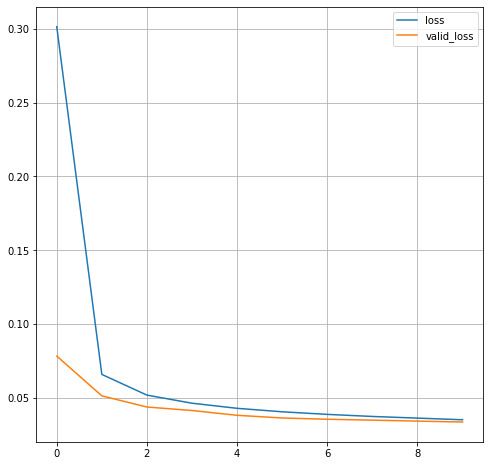

In [16]:
pd.DataFrame({'loss':history.history['loss'],
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))
plt.grid(True)

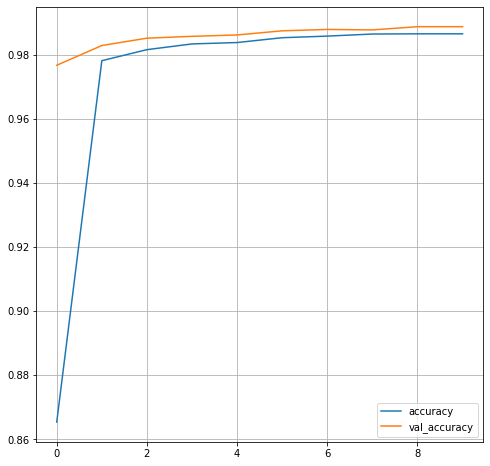

In [17]:
pd.DataFrame({'accuracy':history.history['accuracy'],
              'val_accuracy':history.history['val_accuracy']
              }).plot(figsize=(8, 8))
plt.grid(True)

In [0]:
model.save("densenet.h5")

#Fine tune

In [0]:
densenet.trainable = True

In [20]:
len(densenet.layers)

595

In [0]:
fine_tune_at = 550
for layer in densenet.layers[:fine_tune_at]:
  layer.trainable =  False

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.00001),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 5, 5, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 1,438,273
Non-trainable params: 11,206,272
_________________________________________________________________


In [23]:
total_epochs =  20

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=valid_batches)

Epoch 10/20
437/437 [==============================] - 70s 161ms/step - loss: 0.0533 - accuracy: 0.9834 - val_loss: 0.0367 - val_accuracy: 0.9885
Epoch 11/20
437/437 [==============================] - 69s 157ms/step - loss: 0.0450 - accuracy: 0.9834 - val_loss: 0.0337 - val_accuracy: 0.9891
Epoch 12/20
437/437 [==============================] - 68s 155ms/step - loss: 0.0413 - accuracy: 0.9849 - val_loss: 0.0321 - val_accuracy: 0.9898
Epoch 13/20
437/437 [==============================] - 67s 154ms/step - loss: 0.0348 - accuracy: 0.9871 - val_loss: 0.0310 - val_accuracy: 0.9900
Epoch 14/20
437/437 [==============================] - 67s 154ms/step - loss: 0.0335 - accuracy: 0.9874 - val_loss: 0.0303 - val_accuracy: 0.9901
Epoch 15/20
437/437 [==============================] - 67s 153ms/step - loss: 0.0323 - accuracy: 0.9870 - val_loss: 0.0300 - val_accuracy: 0.9907
Epoch 16/20
437/437 [==============================] - 67s 154ms/step - loss: 0.0278 - accuracy: 0.9898 - val_loss: 0.0293 -

In [24]:
model.evaluate(test_batches)

73/73 [==============================] - 6s 80ms/step - loss: 0.0343 - accuracy: 0.9867


[0.034257806837558746, 0.9866724014282227]

In [0]:
model.save("densenet_finetuned.h5")